In [1]:
import drjit as dr
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from PDE2D import  GreenSampling, Split
from mitsuba import Float, Point2f
from PDE2D.utils.imageUtils import *

In [2]:
green = GreenSampling.Polynomial
split = Split.Naive
max_z = 4
newton_steps = 10

In [3]:
rad = Float(1.0)
source_rad = Float(0.3)
source_val = Float(12)

In [4]:
source_p = {}
source_p["radius"] = source_rad
source_p["val"] = source_val
def source_generator(points, params):
    return dr.select(dr.norm(points) < params["radius"], params["val"], 0.0)


dirichlet_p = {}
dirichlet_p['freq'] = 2
dirichlet_p['bias'] = 1
def dirichlet_generator(points, params):
    return dr.cos(params['freq'] * dr.atan2(points[0], points[1])) + params["bias"]

In [5]:
s = 1
bbox = [[-1.05 * rad * s, -1.05 * rad * s], [1.05 * rad * s, 1.05 * rad * s]]
resolution_image = [256, 256]
spp_image = 2048
epsilon = 1e-5
out_val = 0.1

image = np.zeros([16,16])
image[4,4] = 1
image *= 100 
image += out_val
#α = DiskTextureCoefficient("diffusion", image, radius = rad, constant_thickness= 0.05, origin = [0,0], out_val = out_val)
α = TextureCoefficient("diffusion", bbox, tensor_np = image)
dirichlet = FunctionCoefficient("dirichlet", dirichlet_p, dirichlet_generator)
neumann = ConstantCoefficient("neumann",0)
σ = ConstantCoefficient("screening", 0)
f = FunctionCoefficient("source", source_p, source_generator)
shape = CircleShape(origin=Point2f(0., 0.), radius=rad, epsilon= epsilon,dirichlet=[dirichlet])
data_holder = DataHolder(shape = shape, α = α, σ = σ, f=f, majorant_safety_low=1.05, majorant_safety_high = 1.05)
data_holder.create_accelaration()
print(data_holder.σ_bar)

[1790.66]


Text(0.5, 1.0, 'Diffusion')

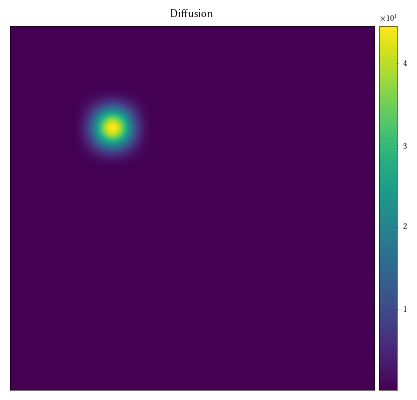

In [6]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
data_holder.α.visualize(ax, bbox = data_holder.bbox);
ax.set_title("Diffusion")

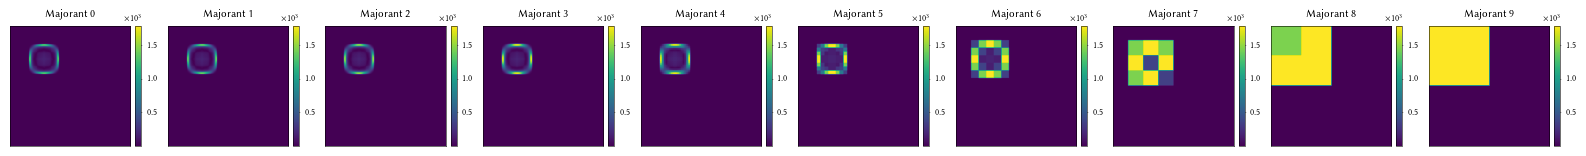

In [7]:
n = 0
fig, axs = plt.subplots(1,10, figsize = (20,5))
for i, ax in enumerate(axs):
    plot_image(data_holder.σ_mipmap[i].numpy(), ax)
    ax.set_title(f"Majorant {i}")

In [8]:
wos = WosVariable(data_holder, seed = 21, use_accelaration = False, green_sampling=green, newton_steps=newton_steps)
wos_a = WosVariable(data_holder, seed = 34, use_accelaration = True, green_sampling=green, newton_steps=newton_steps)
points = create_image_points(bbox, resolution_image, spp_image)

In [9]:
L, p = wos.solve(points_in = points, split = split)
image, tensor = create_image_from_result(L, resolution_image)

In [10]:
L_a, p_a = wos_a.solve(points_in = points, split = split)
image_a, tensor = create_image_from_result(L_a, resolution_image)

Text(0.5, 1.0, 'Accelerated')

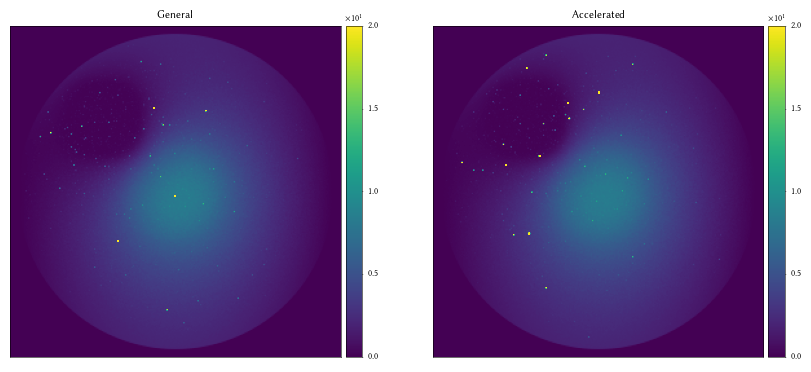

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
max_range = 20
plot_image(image[0], ax1, input_range =[0, max_range])
plot_image(image_a[0], ax2, input_range = [0,max_range])
ax1.set_title("General")
ax2.set_title("Accelerated")

Mean:
-0.01992336
Variance:
25.912539


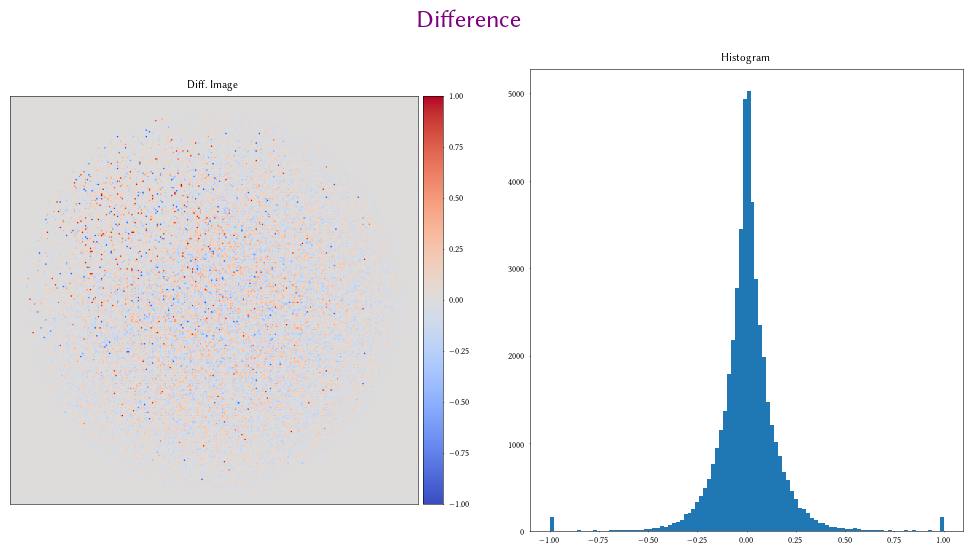

In [13]:
sketch_diff(image[0], image_a[0], max_range = 1)

(0.0, 26843545.6)

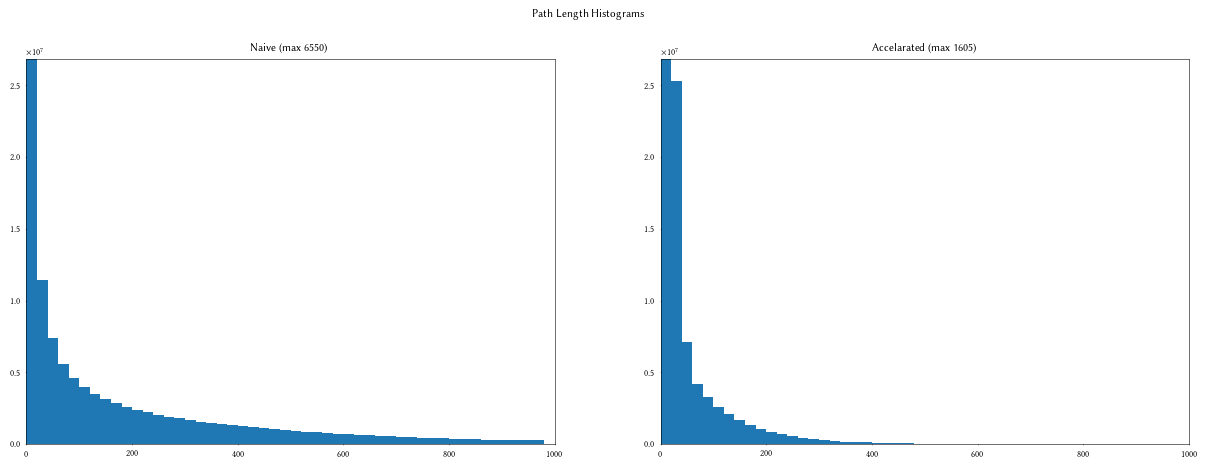

In [14]:
max_range = 1000  
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.hist(p.path_length.numpy(), bins=np.arange(0, max_range, 20));
ax2.hist(p_a.path_length.numpy(),bins =np.arange(0,max_range,20));
ax1.set_xlim([0,max_range])
ax2.set_xlim([0,max_range])
ax1.set_title(f"Naive (max {dr.max(p.path_length)[0]})")
ax2.set_title(f"Accelarated (max {dr.max(p_a.path_length)[0]})")
fig.suptitle("Path Length Histograms")
ax1.set_ylim([0,dr.width(p.path_length) * 0.2])
ax2.set_ylim([0,dr.width(p.path_length) * 0.2])